# <font face='gotham' color='purple'> Credit Risk Modeling and Analysis </font>
## <font face='serif'> Developer: [Juan Fraderick](https://www.linkedin.com/in/juanfraderick/)</font>

<font face='serif' color=gray> Thank you for clicking and reviewing my project. This is my first time developing a credit risk model, so I'm open to any feedbacks and comments. That said, this notebook is both a demonstration on how I can implement state-of-the-art data science techniques in finance and how I understand risk management. By the end of this notebook, I will cite all developers and resource that I use to base my assumptions and/or get inspired with their approach.</font>

<font face='serif' color='gray'>A bit about me, I am a rising junior at the Chinese University of Hong Kong (CUHK) studying global economics and finance (GLEF), with a minor in statistics. In a professional setting, I describe myself as a data nerd with love for econometrics and quantitative applications in finance. However, in a personal setting, I am willing to try out multiple professional shoes until it fits right. Please find more about me on my [LinkedIn](https://www.linkedin.com/in/juanfraderick/) profile and let's connect!</font>

## <font face='gotham' color='purple'>1. Exploring Loss-Given-Default (LGD) Model</font>

<font face='serif'>Loss given default is an important calculation for financial institutions projecting out their expected losses due to borrowers defaulting on loans. LGD is depicted as a percentage of total exposure at the time of default or a single dollar value of potential loss and often refer to an investment's 'loss severity'. There are three approaches to find expected LGD, which are 1). the scorecard approach, 2). the market-implied approach, and 3). the statistical approach. For this project, I will use the later and apply to the dataset of loan defaults from 2007 to 2014 that I obtain from Kaggle.</font>

<font face='serif'> First, I import relevant libraries and did some data pre-processing.</font>

In [50]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set()
pd.options.mode.chained_assignment=None

In [51]:
#importing the CSV data
df_backup = pd.read_csv('loan_data_2007_2014_preprocessed.csv', low_memory=False)
df = df_backup.copy()
#displaying all the imported column
df.columns.values

array(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

In [52]:
df.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1


In [53]:
#Taking the accounts that were written or charged-off
defaults = df[df['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status: Charged off'])]
defaults.shape

(42475, 209)

In [54]:
#Setting the dataframe option to display all columns and row
pd.options.display.max_rows=None
defaults.isnull().sum()

Unnamed: 0.1                                                           0
Unnamed: 0                                                             0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3237
emp_length                                         

In [55]:
#Filling the missing values of the dataset with 0s
defaults['mths_since_last_delinq'].fillna(0, inplace=True)
defaults['mths_since_last_record'].fillna(0, inplace=True)
#Calculating the dependent variable (y) for the LGD model, which is the ratio of recoveries and funded amount
defaults['recovery_rate'] = defaults['recoveries'] / defaults['funded_amnt']
#Setting the recovery rate that is higher than 1 to 1, and lower than 0 to 0
defaults['recovery_rate'] = np.where(defaults['recovery_rate'] > 1, 1, defaults['recovery_rate'])
defaults['recovery_rate'] = np.where(defaults['recovery_rate'] < 0, 0, defaults['recovery_rate'])
#Showing the descriptive statistics
defaults['recovery_rate'].describe()

count    42475.000000
mean         0.060763
std          0.087586
min          0.000000
25%          0.000000
50%          0.030302
75%          0.114715
max          1.000000
Name: recovery_rate, dtype: float64

(array([2.032e+04, 3.300e+02, 5.650e+02, 1.089e+03, 1.837e+03, 1.930e+03,
        6.430e+02, 7.430e+02, 8.950e+02, 1.234e+03, 1.548e+03, 1.788e+03,
        2.312e+03, 2.445e+03, 1.039e+03, 6.710e+02, 7.010e+02, 4.720e+02,
        1.930e+02, 2.060e+02, 1.860e+02, 1.500e+02, 1.590e+02, 1.150e+02,
        5.500e+01, 5.500e+01, 4.200e+01, 4.900e+01, 4.600e+01, 3.500e+01,
        3.900e+01, 3.300e+01, 2.900e+01, 2.500e+01, 3.100e+01, 3.800e+01,
        2.700e+01, 2.700e+01, 1.400e+01, 1.300e+01, 2.600e+01, 1.800e+01,
        1.700e+01, 1.000e+01, 6.000e+00, 1.000e+01, 5.000e+00, 1.000e+01,
        1.000e+01, 9.000e+00, 1.200e+01, 1.000e+01, 9.000e+00, 8.000e+00,
        3.000e+00, 4.000e+00, 3.000e+00, 6.000e+00, 2.000e+00, 4.000e+00,
        3.000e+00, 5.000e+00, 5.000e+00, 1.000e+00, 4.000e+00, 3.000e+00,
        5.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 5.000e+00, 4.000e+00,
        3.000e+00, 1.000e+00, 2.000e+00, 8.000e+00, 6.000e+00, 2.000e+00,
        2.000e+00, 7.000e+00, 3.000e+0

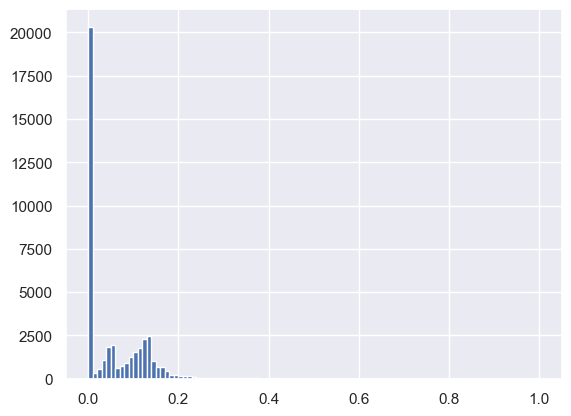

In [56]:
#Plotting a histogram of recoveries with 100 bins
plt.hist(defaults['recovery_rate'], bins=100)

In [57]:
#Creating new variable which states 0 if recovery rate is 0 and 1 if otherwise
defaults['recovery_rate_0_1'] = np.where(defaults['recovery_rate'] == 0, 0, 1)
defaults['good_bad'] = np.where(defaults['loan_status'].isin(['Charged Off','Default','Does not meet the credit policy. Status:Charged Off','Late (31-120 days)']), 0, 1)
defaults.to_csv('defaults.csv')

## <font face='gotham' color='purple'>2. Preparing the Logistic Regression Model</font>

In [58]:
#Stage 1 modeling: recovery rate variable is 0 or greater than 0 by taking set of inputs and targets as arguments.
#Splitting into four dataframes: 'inputs-train', 'inputs-test', 'targets-train', and 'targets-test'.
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(defaults.drop(['good_bad','recovery_rate','recovery_rate_0_1'], axis=1), defaults['recovery_rate_0_1'], test_size=0.2, random_state=42)

In [59]:
#List of all independent variables (x) of the LGD model
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [60]:
#List of the dummy variable reference categories
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [61]:
train_df = defaults.reindex(defaults.columns.tolist() + features_all, axis = 1)

In [62]:
#Keep the variables I need for the model
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]

In [63]:
#Remove the dummy variables reference categories
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)

In [64]:
#Check missing values and sum accross values
lgd_inputs_stage_1_train.isnull().sum()

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

In [65]:
#P-values for sklearn logistic regression
class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)

        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) 
        Cramer_Rao = np.linalg.inv(F_ij) 
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] 
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [66]:
#Create an instance of an object from the 'LogisticRegression' class.
reg_lgd_st_1 = LogisticRegression_with_p_values()
#Estimates the coefficients of the object from the 'LogisticRegression' class
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)
#Stores the names of the columns of a dataframe in a variable
feature_name = lgd_inputs_stage_1_train.columns.values

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
#Creates a summary table dataframe 
summary_table = pd.DataFrame(columns=['Feature name'], data=feature_name)
#The values of dataframe rows are transposed coefficients from the 'LogisticRegression' object.
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
#Increases the index of every row of the dataframe with 1.
summary_table.index = summary_table.index + 1
#Assigns values of the row with index 0 of the dataframe.
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
#Sorts the dataframe by index.
summary_table = summary_table.sort_index()
#We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = reg_lgd_st_1.p_values
#We add the value 'NaN' in the beginning of the variable with p-values.
p_values = np.append(np.nan,np.array(p_values))
#In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-2.669541e-04,NaN
1,grade:A,-3.687717e-05,9.996677e-01
2,grade:B,-1.901713e-04,9.978767e-01
3,grade:C,-2.313481e-04,9.973008e-01
4,grade:D,-5.226681e-06,9.999409e-01
5,grade:E,4.394433e-05,9.995481e-01
6,grade:F,1.354155e-04,9.987896e-01
7,home_ownership:MORTGAGE,-1.333938e-04,9.958598e-01
8,home_ownership:NONE,1.957017e-06,9.999980e-01
9,home_ownership:OTHER,1.153127e-06,9.999982e-01


## <font face='gotham' color='purple'>3. Testing the Logistic Regression Model</font>

In [68]:
#Here we keep only the variables we need for the model.
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]
#Here we remove the dummy variable reference categories.
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)
y_hat_test_lgd_stage_1

array([1, 0, 1, ..., 1, 1, 0])

In [69]:
# Calculates the predicted probability values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)
# This is an array of arrays of predicted class probabilities for all classes.
# In this case, the first value of every sub-array is the probability for the observation to belong to the first class, i.e. 0,
# and the second value is the probability for the observation to belong to the first class, i.e. 1.
y_hat_test_proba_lgd_stage_1

array([[0.39544589, 0.60455411],
       [0.69910554, 0.30089446],
       [0.31936135, 0.68063865],
       ...,
       [0.49578272, 0.50421728],
       [0.46296146, 0.53703854],
       [0.51721012, 0.48278988]])

In [70]:
# Here we take all the arrays in the array, and from each array, we take all rows, and only the element with index 1,
# that is, the second element.
# In other words, we take only the probabilities for being 1.
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[: ][: , 1]
y_hat_test_proba_lgd_stage_1

array([0.60455411, 0.30089446, 0.68063865, ..., 0.50421728, 0.53703854,
       0.48278988])

In [71]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test
# We reset the index of a dataframe.
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)
# Concatenates two dataframes.
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis = 1)
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']
# Makes the index of one dataframe equal to the index of another dataframe.
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
88068,1,0.604554
340018,0,0.300894
3816,0,0.680639
29236,0,0.764936
109278,1,0.607325


In [72]:
tr = 0.5
# We create a new column with an indicator,
# where every observation that has predicted probability greater than the threshold has a value of 1,
# and every observation that has predicted probability lower than the threshold has a value of 0.
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)
# Creates a cross-table where the actual values are displayed by rows and the predicted values by columns.
# This table is known as a Confusion Matrix.
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,1377,2321
1,952,3845


In [73]:
# Here we divide each value of the table by the total number of observations,
# thus getting percentages, or, rates.
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.162095,0.273220
1,0.112066,0.452619


In [74]:
# Here we calculate Accuracy of the model, which is the sum of the diagonal rates.
(pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

0.614714537963508

Text(0.5, 1.0, 'ROC curve')

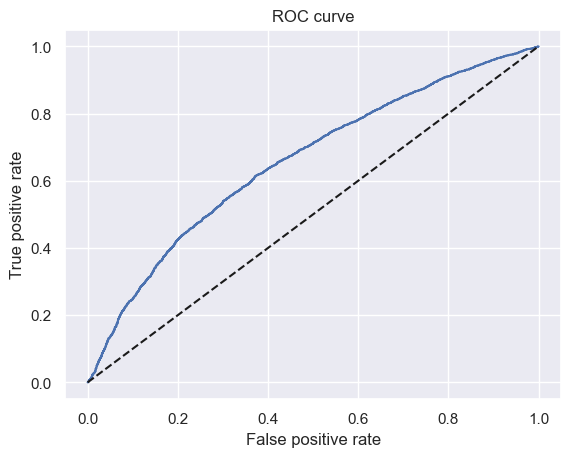

In [75]:
# Returns the Receiver Operating Characteristic (ROC) Curve from a set of actual values and their predicted probabilities.
# As a result, we get three arrays: the false positive rates, the true positive rates, and the thresholds.
# we store each of the three arrays in a separate variable.
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, tpr)
# We plot a seconary diagonal line, with dashed line style and black color.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We name the x-axis "False positive rate".
plt.xlabel('False positive rate')
# We name the x-axis "True positive rate".
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [76]:
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
# Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC)
# from a set of actual values and their predicted probabilities.
AUROC

0.6572907079904929

In [77]:
pickle.dump(reg_lgd_st_1, open('lgd_model_stage_1.sav', 'wb'))

## <font face='gotham' color='purple'>4. Preparing the Linear Regression Model</font>

In [78]:
# Here we take only rows where the original recovery rate variable is greater than one,
# i.e. where the indicator variable we created is equal to 1.
lgd_stage_2_data = defaults[defaults['recovery_rate_0_1'] == 1]
# LGD model stage 2 datasets: how much more than 0 is the recovery rate
# Takes a set of inputs and a set of targets as arguments. Splits the inputs and the targets into four dataframes:
# Inputs - Train, Inputs - Test, Targets - Train, Targets - Test.
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(['good_bad', 'recovery_rate','recovery_rate_0_1'], axis = 1), lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

In [79]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat
# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are tandp which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        
        super().__init__(fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X, n_jobs=n_jobs, positive=False)
        self.positive = positive
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        self.t = self.coef_ / se
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [80]:
class LinearRegression(linear_model.LinearRegression):

    def __init__(self, fit_intercept=True, normalize=False, copy_X=True, n_jobs=1, positive=False):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
        self.positive = positive

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        self.t = self.coef_ / se
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [81]:
# Here we keep only the variables we need for the model.
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]
# Here we remove the dummy variable reference categories.
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [82]:
# We create an instance of an object from the 'LogisticRegression' class.
reg_lgd_st_2 = LinearRegression()
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

LinearRegression()

In [83]:
# Stores the names of the columns of a dataframe in a variable.
feature_name = lgd_inputs_stage_2_train.columns.values
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
# Increases the index of every row of the dataframe with 1.
summary_table.index = summary_table.index + 1
# Assigns values of the row with index 0 of the dataframe.
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
# Sorts the dataframe by index.
summary_table = summary_table.sort_index()
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = reg_lgd_st_2.p
# We add the value 'NaN' in the beginning of the variable with p-values.
p_values = np.append(np.nan,np.array(p_values))
# In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table['p_values'] = p_values.round(3)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.264341e-01,NaN
1,grade:A,-4.815164e-02,0.000
2,grade:B,-3.688998e-02,0.000
3,grade:C,-2.532823e-02,0.000
4,grade:D,-1.739225e-02,0.000
5,grade:E,-6.432096e-03,0.126
6,grade:F,-1.451865e-03,0.761
7,home_ownership:MORTGAGE,3.681100e-03,0.011
8,home_ownership:NONE,2.727074e-01,0.000
9,home_ownership:OTHER,-4.963639e-03,0.831


## <font face='gotham' color='purple'>5. Testing the Linear Regression Model</font>

In [84]:
# Here we keep only the variables we need for the model.
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]
# Here we remove the dummy variable reference categories.
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.
lgd_inputs_stage_2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [85]:
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test
# We reset the index of a dataframe.
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)
# We calculate the correlation between actual and predicted values.
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.318349
0,0.318349,1.000000


/var/folders/y0/45y9vkkx3zxc3sfrn89_zcmc0000gn/T/ipykernel_1960/1897700511.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)


<Axes: xlabel='recovery_rate', ylabel='Density'>

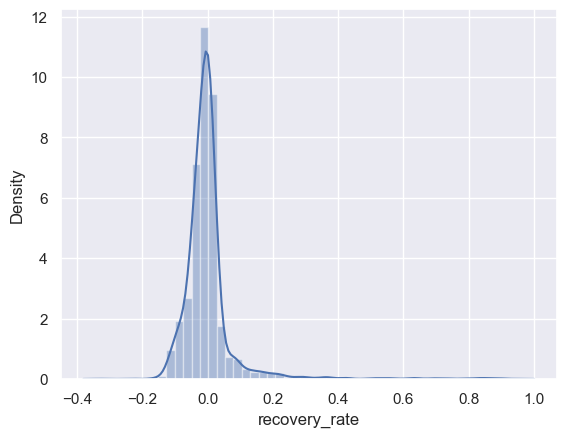

In [86]:
# We plot the distribution of the residuals.
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)

In [87]:
pickle.dump(reg_lgd_st_2, open('lgd_model_stage_2.sav', 'wb'))

## <font face='gotham' color='purple'>6. Combining the Logistic and Linear Regression Model</font>

In [88]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)
y_hat_test_lgd_stage_2_all

array([0.10610923, 0.15761235, 0.09715261, ..., 0.14875221, 0.08835487,
       0.13009296])

In [89]:
# Here we combine the predictions of the models from the two stages.
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all
# Shows some descriptive statisics for the values of a column.
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8495.000000
mean,0.075898
std,0.052296
min,-0.014771
25%,0.000000
50%,0.093473
75%,0.117353
max,0.199000


In [90]:
# We set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0.
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)

In [91]:
# Shows some descriptive statisics for the values of a column.
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8495.000000
mean,0.075902
std,0.052292
min,0.000000
25%,0.000000
50%,0.093473
75%,0.117353
max,0.199000
